# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 1, #number of variables
        'monomial_vars': None, #int or None
        'laurent': True, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 1,#int or None
        'neg_d_prob': 0.2,
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0.05,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0.001,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': None, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': True,

        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': -3,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [5]:
from utilities.utility_functions import flatten, rec_gen

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    print(list_of_monomial_identifiers_extended)        
else:
    variable_sets = [[_d for _d in range(d+1)] for _ in range(n)]  
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)

    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity: ' + str(sparsity))
    print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    if np.sum(monomial_identifier) <= d:
        if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
            list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 5
[[0], [1], [2], [3], [-1]]


  0%|          | 0/5 [00:00<?, ?it/s]

List length: 5
[[0], [1], [2], [3], [-1]]


In [6]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_5_drop0.25e500b256_custom/lnets_10000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_1_d_3_laurent_negd_1_prob_0.2_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0.001bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_10000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_1_d_3_laurent_negd_1_prob_0.2_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0.001bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [9]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [10]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=-3)]: Using backend MultiprocessingBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:   12.1s finished


## Data Inspection

In [11]:
lambda_net_dataset.as_pandas().head()

,seed,0-target,1-target,2-target,3-target,-1-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,-1-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,-1-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75
6252,1373158606,-0.668,-0.295,-0.337,0.000,0.000,-0.697,-0.130,-0.656,0.203,0.001,-0.668,-0.295,-0.336,-0.001,-0.000,-0.010,-0.248,0.205,0.137,0.224,0.058,0.237,-0.324,0.115,0.358,0.371,-0.096,-0.021,0.269,0.195,0.319,0.009,0.469,0.254,0.401,0.038,0.087,0.079,-0.046,-0.441,0.000,0.000,-0.020,-0.004,-0.042,0.014,0.028,0.000,0.001,0.109,0.015,0.000,0.000,0.015,0.006,-0.022,-0.025,-0.270,-0.054,-0.163,-0.043,0.005,0.071,0.000,0.000,-0.278,-0.392,-0.247,-0.287,-0.194,-0.076,-0.141,-0.445,-0.324,-0.068,-0.107,-0.385,-0.397,-0.139,-0.186,-0.161,0.430,-0.389,-0.163,-0.290,0.055,-0.387,-0.155,-0.285,-0.418,-0.639
4684,1373158606,0.087,0.000,0.000,0.000,0.000,0.088,-0.005,0.010,-0.006,-0.000,0.087,0.000,-0.001,0.000,-0.000,-0.010,-0.248,0.132,0.069,0.119,0.081,0.164,-0.324,0.052,0.291,0.322,-0.096,-0.021,0.192,0.083,0.220,0.001,0.233,0.173,0.203,0.031,0.025,0.011,-0.046,-0.441,0.000,0.000,-0.111,-0.062,-0.105,-0.078,-0.048,0.000,-0.045,-0.037,-0.086,0.000,0.000,-0.076,-0.061,-0.157,-0.003,-0.057,-0.141,-0.095,-0.022,-0.025,-0.023,0.000,0.000,-0.278,-0.392,-0.189,-0.214,0.161,0.215,-0.003,-0.445,-0.248,-0.000,-0.001,-0.385,-0.397,-0.014,0.130,-0.091,0.436,0.001,0.175,0.027,0.057,-0.307,-0.050,-0.285,-0.418,0.087
1731,1373158606,0.000,0.754,0.007,0.620,-0.023,-0.327,1.725,-1.038,0.958,0.009,0.000,0.754,0.008,0.619,-0.023,-0.010,-0.248,0.138,0.093,0.379,0.326,0.120,-0.324,0.076,0.724,0.532,-0.096,-0.021,0.442,0.361,0.457,0.320,0.499,0.413,0.475,0.368,0.046,0.010,-0.046,-0.441,0.000,0.000,-0.139,-0.094,-0.043,-0.038,-0.120,0.000,-0.079,-0.424,-0.060,0.000,0.000,-0.052,-0.041,-0.053,-0.233,-0.059,-0.048,-0.053,-0.043,-0.053,-0.024,0.000,0.000,-0.278,-0.392,-0.198,-0.246,0.336,0.387,-0.022,-0.445,-0.283,0.508,0.243,-0.385,-0.397,0.290,0.352,0.275,1.097,0.258,0.315,0.267,0.349,-0.340,-0.049,-0.285,-0.418,-0.079
4742,1373158606,-0.141,-0.028,0.000,0.720,0.000,-0.069,-0.418,0.730,0.291,-0.004,-0.141,-0.027,-0.000,0.720,0.000,-0.010,-0.248,0.043,-0.047,0.369,0.333,0.197,-0.324,-0.051,0.478,0.340,-0.096,-0.021,0.216,0.344,0.255,0.226,0.430,0.413,0.421,0.308,-0.084,0.006,-0.046,-0.441,0.000,0.000,-0.043,0.029,-0.263,-0.232,-0.045,0.000,0.032,-0.142,-0.080,0.000,0.000,-0.046,-0.209,-0.058,-0.152,-0.157,-0.236,-0.180,-0.146,0.047,-0.025,0.000,0.000,-0.278,-0.392,-0.090,-0.185,0.506,0.570,0.063,-0.445,-0.237,0.159,0.058,-0.385,-0.397,0.052,0.477,0.060,0.880,0.253,0.436,0.286,0.406,-0.349,-0.045,-0.285,-0.418,-0.118
4521,1373158606,0.556,-0.481,-0.434,0.000,-0.348,-1.549,8.081,-13.475,6.556,-0.188,0.556,-0.480,-0.435,0.000,-0.348,-0.010,-0.248,0.140,-0.981,0.106,-0.002,-0.034,-0.324,-0.733,0.035,0.237,-0.096,-0.021,0.117,0.075,0.170,0.010,0.584,0.233,0.546,0.063,-1.850,-3.894,-0.046,-0.441,0.000,0.000,-0.089,0.348,-0.006,-0.001,0.039,0.000,0.355,0.147,-0.017,0.000,0.000,-0.008,-0.005,-0.011,-0.025,-0.476,-0.149,-0.367,-0.005,0.442,0.590,0.000,0.000,-0.278,-0.392,-0.261,-1.659,0.024,0.100,-0.012,-0.445,-1.497,0.002,0.009,-0.385,-0.397,0.024,0.031,0.015,0.430,-0.530,-0.244,-0.676,0.034,-2.874,-4.704,-0.285,-0.418,-0.485


In [12]:
lambda_net_dataset.as_pandas().describe()

,seed,0-target,1-target,2-target,3-target,-1-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,-1-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,-1-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,1373158606.000,-0.008,-0.009,0.006,-0.001,-0.002,-0.023,0.069,-0.116,0.059,-0.001,-0.008,-0.009,0.006,-0.001,-0.002,-0.010,-0.248,0.124,0.002,0.114,0.023,0.138,-0.324,-0.045,0.175,0.349,-0.096,-0.021,0.214,0.024,0.271,-0.204,0.273,0.207,0.262,-0.122,-0.132,-0.251,-0.046,-0.441,0.000,0.000,-0.046,-0.016,-0.034,-0.021,-0.021,0.000,-0.013,0.035,-0.050,0.000,0.000,-0.025,-0.012,-0.055,0.020,-0.045,-0.060,-0.038,0.017,0.002,0.045,0.000,0.000,-0.278,-0.392,-0.355,-0.493,0.310,0.451,-0.205,-0.445,-0.588,0.052,-0.086,-0.385,-0.397,-0.150,0.377,-0.182,0.897,0.102,0.268,0.130,0.468,-0.737,-0.526,-0.285,-0.418,-0.002
std,0.000,0.507,0.482,0.485,0.491,0.250,1.535,6.030,9.318,4.720,0.149,0.507,0.482,0.485,0.491,0.250,0.000,0.000,0.351,0.520,0.386,0.512,0.471,0.000,0.625,0.739,0.297,0.000,0.000,0.334,0.556,0.304,0.936,0.373,0.298,0.329,0.900,0.801,1.113,0.000,0.000,0.000,0.000,0.169,0.162,0.171,0.167,0.185,0.000,0.163,0.275,0.197,0.000,0.000,0.178,0.170,0.173,0.163,0.218,0.176,0.188,0.190,0.166,0.187,0.000,0.000,0.000,0.000,0.369,0.595,0.414,0.576,0.497,0.000,0.748,0.657,0.307,0.000,0.000,0.352,0.615,0.304,1.204,0.402,0.314,0.353,0.991,1.006,1.259,0.000,0.000,0.566
min,1373158606.000,-1.000,-1.000,-1.000,-1.000,-0.998,-10.822,-34.269,-58.052,-26.564,-0.798,-1.000,-0.999,-1.000,-1.001,-0.998,-0.010,-0.248,-3.953,-3.383,-4.152,-3.858,-4.024,-0.324,-4.057,-4.125,-2.474,-0.096,-0.021,-3.210,-4.355,-4.955,-6.069,-1.729,-4.684,-2.281,-5.101,-4.611,-7.171,-0.046,-0.441,0.000,0.000,-0.515,-0.594,-0.474,-0.495,-0.690,0.000,-0.403,-0.848,-0.954,0.000,0.000,-0.640,-0.475,-0.531,-0.391,-0.866,-0.654,-0.741,-0.416,-0.361,-0.504,0.000,0.000,-0.278,-0.392,-4.444,-4.369,-1.299,-0.330,-4.307,-0.445,-5.384,-2.403,-2.216,-0.385,-0.397,-3.238,-1.343,-5.272,0.215,-1.897,-1.209,-1.383,-0.989,-6.532,-8.626,-0.285,-0.418,-2.882
25%,1373158606.000,-0.374,-0.303,-0.286,-0.298,0.000,-0.472,-0.457,-0.620,-0.299,-0.003,-0.374,-0.303,-0.286,-0.299,-0.000,-0.010,-0.248,0.098,0.027,0.087,0.016,0.131,-0.324,0.023,0.209,0.326,-0.096,-0.021,0.188,0.048,0.241,-0.004,0.246,0.149,0.230,0.011,0.016,-0.008,-0.046,-0.441,0.000,0.000,-0.146,-0.095,-0.129,-0.103,-0.119,0.000,-0.083,-0.118,-0.162,0.000,0.000,-0.135,-0.092,-0.172,-0.025,-0.145,-0.170,-0.147,-0.048,-0.052,-0.024,0.000,0.000,-0.278,-0.392,-0.429,-0.461,0.128,0.201,-0.254,-0.445,-0.517,-0.135,-0.209,-0.385,-0.397,-0.247,0.130,-0.291,0.430,-0.006,0.109,-0.001,0.054,-0.629

In [13]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.09742011],
       [0.58135332],
       [0.44154658],
       [0.49844236],
       [0.53167368],
       [0.39229372],
       [0.5088565 ],
       [0.9205092 ],
       [0.3090224 ],
       [0.88738317]])

In [14]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[-0.69916664],
       [-0.95379083],
       [-0.86441286],
       [-0.89857432],
       [-0.91995172],
       [-0.83622957],
       [-0.90632973],
       [-1.22460278],
       [-0.79134678],
       [-1.19512095]])

## Generate Datasets for Interpretation-Net training

In [15]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        
        if isinstance(test_size, float):
            test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))
        
        test_seeds = random.sample(complete_seed_list, test_size)
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [16]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8910, 92)

In [17]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(990, 92)

In [18]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 92)

In [19]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,-1-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,-1-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,-1-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75
5548,1373158606,-0.196,0.064,0.800,0.130,0.000,-0.125,-0.379,1.687,-0.419,-0.003,-0.196,0.064,0.800,0.131,0.000,-0.010,-0.248,-0.046,-0.278,0.378,0.345,0.335,-0.324,0.064,0.548,0.436,-0.096,-0.021,0.359,0.372,0.343,0.251,0.432,0.404,0.424,0.361,0.046,0.009,-0.046,-0.441,0.000,0.000,0.025,0.119,-0.160,-0.219,-0.048,0.000,-0.076,-0.179,-0.067,0.000,0.000,-0.038,-0.176,-0.037,-0.175,-0.098,-0.165,-0.115,-0.177,-0.059,-0.026,0.000,0.000,-0.278,-0.392,-0.072,-0.465,0.380,0.539,0.177,-0.445,-0.266,0.186,0.141,-0.385,-0.397,0.167,0.439,0.143,0.917,0.202,0.340,0.234,0.472,-0.337,-0.048,-0.285,-0.418,-0.134
1854,1373158606,-0.477,-0.999,0.207,-0.263,0.000,-0.486,-0.859,-0.272,0.136,0.000,-0.477,-0.999,0.206,-0.263,-0.000,-0.010,-0.248,0.333,0.259,0.116,0.088,0.369,-0.324,0.225,0.510,0.490,-0.096,-0.021,0.396,0.086,0.440,0.010,0.340,0.147,0.271,0.038,0.182,0.240,-0.046,-0.441,0.000,0.000,0.014,0.035,-0.116,-0.088,0.071,0.000,0.037,0.124,0.034,0.000,0.000,0.056,-0.086,0.011,-0.024,-0.104,-0.147,-0.085,-0.042,0.041,0.127,0.000,0.000,-0.278,-0.392,-0.346,-0.373,0.149,0.207,-0.244,-0.445,-0.399,-0.165,-0.220,-0.385,-0.397,-0.244,0.135,-0.274,0.430,-0.167,0.133,-0.115,0.055,-0.450,-0.254,-0.285,-0.418,-0.333
739,1373158606,-0.271,0.000,-0.800,-0.270,-0.481,-1.885,6.891,-11.588,5.265,-0.369,-0.271,-0.001,-0.798,-0.271,-0.481,-0.010,-0.248,-0.968,-1.404,0.395,-0.001,-1.279,-0.324,-1.521,-0.958,-0.620,-0.096,-0.021,-0.909,0.204,-0.668,0.010,0.373,0.474,0.724,0.037,-2.634,-5.524,-0.046,-0.441,0.000,0.000,0.313,0.340,-0.267,-0.001,0.355,0.000,0.352,0.416,0.349,0.000,0.000,0.342,-0.142,0.337,-0.025,-0.248,-0.358,-0.629,-0.043,0.439,0.635,0.000,0.000,-0.278,-0.392,-1.421,-2.010,-0.826,0.154,-1.482,-0.445,-2.250,-0.898,-0.798,-0.385,-0.397,-1.142,-0.460,-0.962,0.430,-0.358,-0.897,-0.696,0.054,-3.732,-6.519,-0.285,-0.418,-1.427
3588,1373158606,0.543,0.131,0.806,-0.528,-0.727,-4.922,23.521,-35.675,17.991,-0.356,0.544,0.130,0.809,-0.530,-0.727,-0.010,-0.248,-1.311,-2.184,0.411,0.378,-1.798,-0.324,-2.639,-1.132,-0.833,-0.096,-0.021,-1.159,0.411,-0.738,0.244,0.514,0.458,0.499,0.417,-3.009,-3.130,-0.046,-0.441,0.000,0.000,0.470,0.484,-0.189,-0.187,0.507,0.000,0.486,0.574,0.481,0.000,0.000,0.524,-0.205,0.478,-0.119,-0.235,-0.224,-0.232,-0.216,0.482,0.512,0.000,0.000,-0.278,-0.392,-1.867,-3.137,0.436,0.557,-2.212,-0.445,-3.775,-1.105,-0.939,-0.385,-0.397,-1.519,0.529,-0.982,0.828,0.345,0.436,0.365,0.574,-4.260,-3.792,-0.285,-0.418,-0.557
4649,1373158606,0.975,0.942,-0.032,0.000,0.000,0.982,0.900,0.075,-0.065,-0.000,0.975,0.943,-0.033,0.001,0.000,-0.010,-0.248,0.147,0.090,0.314,0.255,0.131,-0.324,0.073,0.479,0.290,-0.096,-0.021,0.167,0.279,0.236,0.103,0.413,0.388,0.410,0.241,0.045,0.010,-0.046,-0.441,0.000,0.000,-0.145,-0.091,0.175,0.169,-0.115,0.000,-0.076,0.308,-0.145,0.000,0.000,-0.129,0.193,-0.172,0.162,0.229,0.153,0.206,0.260,-0.051,-0.024,0.000,0.000,-0.278,-0.392,-0.223,-0.247,0.354,0.397,-0.048,-0.445,-0.283,0.214,-0.022,-0.385,-0.397,-0.052,0.354,-0.120,0.615,0.271,0.364,0.290,0.331,-0.339,-0.049,-0.285,-0.418,0.351


In [20]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,-1-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,-1-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,-1-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75
4197,1373158606,0.094,0.000,-0.529,0.052,0.000,0.059,0.186,-0.862,0.244,0.001,0.094,-0.000,-0.528,0.052,-0.000,-0.010,-0.248,0.276,0.227,0.063,0.020,0.281,-0.324,0.201,0.392,0.393,-0.096,-0.021,0.301,-0.002,0.346,-0.143,0.313,0.120,0.276,-0.143,0.166,0.165,-0.046,-0.441,0.000,0.000,-0.141,-0.132,-0.064,-0.022,-0.108,0.000,-0.138,-0.077,-0.096,0.000,0.000,-0.112,-0.000,-0.118,0.058,-0.053,-0.120,-0.044,0.070,-0.080,-0.052,0.000,0.000,-0.278,-0.392,-0.341,-0.432,0.080,0.146,-0.200,-0.445,-0.496,-0.092,-0.121,-0.385,-0.397,-0.180,0.059,-0.179,0.645,-0.098,0.101,-0.093,0.157,-0.496,-0.272,-0.285,-0.418,0.047
5318,1373158606,0.966,-0.979,0.881,0.865,0.000,0.975,-1.002,0.980,0.713,-0.002,0.966,-0.979,0.880,0.865,0.000,-0.010,-0.248,0.182,0.090,0.047,-0.094,0.906,-0.324,0.073,0.176,0.610,-0.096,-0.021,0.675,-0.034,0.353,-0.495,0.159,0.115,0.150,-0.228,0.045,0.010,-0.046,-0.441,0.000,0.000,-0.069,-0.091,-0.017,0.033,-0.670,0.000,-0.075,0.234,-0.261,0.000,0.000,-0.359,0.012,-0.148,0.128,0.111,-0.038,0.082,0.077,-0.051,-0.024,0.000,0.000,-0.278,-0.392,0.145,-0.247,0.140,0.243,1.469,-0.445,-0.282,0.006,0.484,-0.385,-0.397,0.857,0.148,0.189,0.991,0.009,0.121,0.014,0.219,-0.339,-0.049,-0.285,-0.418,0.767
3815,1373158606,0.030,-0.615,0.773,0.822,0.000,0.114,-0.929,1.235,0.579,-0.008,0.030,-0.615,0.772,0.823,0.000,-0.010,-0.248,0.036,-0.001,0.462,0.424,0.261,-0.324,-0.013,0.633,0.326,-0.096,-0.021,0.223,0.439,0.261,0.307,0.535,0.512,0.533,0.420,0.043,0.010,-0.046,-0.441,0.000,0.000,-0.002,-0.001,-0.272,-0.300,-0.090,0.000,0.013,-0.336,-0.025,0.000,0.000,-0.070,-0.281,-0.085,-0.224,-0.218,-0.236,-0.200,-0.289,-0.058,-0.026,0.000,0.000,-0.278,-0.392,-0.052,-0.173,0.557,0.712,0.141,-0.445,-0.204,0.324,0.010,-0.385,-0.397,0.061,0.614,0.069,1.065,0.357,0.510,0.388,0.656,-0.336,-0.048,-0.285,-0.418,-0.050
9727,1373158606,0.000,0.000,0.692,0.000,0.000,0.023,-0.185,1.104,-0.270,-0.000,-0.000,0.000,0.692,-0.000,0.000,-0.010,-0.248,0.098,0.074,0.285,0.306,0.305,-0.324,0.066,0.539,0.412,-0.096,-0.021,0.329,0.292,0.216,0.209,0.378,0.346,0.367,0.306,0.045,0.010,-0.046,-0.441,0.000,0.000,-0.099,-0.078,-0.065,-0.187,-0.039,0.000,-0.072,-0.221,-0.050,0.000,0.000,-0.040,-0.102,-0.134,-0.152,-0.055,-0.120,-0.073,-0.139,-0.051,-0.024,0.000,0.000,-0.278,-0.392,-0.150,-0.225,0.243,0.502,0.179,-0.445,-0.275,0.194,0.135,-0.385,-0.397,0.173,0.303,0.032,0.883,0.149,0.261,0.174,0.387,-0.339,-0.050,-0.285,-0.418,0.011
5410,1373158606,-0.421,0.887,0.000,0.785,0.000,-0.409,0.589,0.848,0.158,0.003,-0.421,0.888,-0.001,0.785,0.000,-0.010,-0.248,-0.182,0.090,0.508,0.429,0.423,-0.324,0.076,0.634,0.525,-0.096,-0.021,0.459,0.395,0.347,0.330,0.516,0.557,0.504,0.369,0.046,0.009,-0.046,-0.441,0.000,0.000,0.101,-0.098,-0.309,-0.156,-0.049,0.000,-0.086,-0.082,-0.059,0.000,0.000,-0.050,-0.090,-0.024,-0.233,-0.076,-0.289,-0.081,-0.047,-0.059,-0.027,0.000,0.000,-0.278,-0.392,-0.196,-0.236,0.642,0.545,0.277,-0.445,-0.279,0.202,0.205,-0.385,-0.397,0.240,0.398,0.122,1.076,0.258,0.585,0.281,0.362,-0.338,-0.049,-0.285,-0.418,-0.293


In [21]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,-1-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,-1-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,-1-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75
7217,1373158606,0.781,-0.379,-0.130,-0.266,-0.882,-4.877,23.727,-37.622,18.735,-0.489,0.781,-0.378,-0.132,-0.264,-0.882,-0.010,-0.248,-0.892,-2.078,0.232,0.161,-1.441,-0.324,-2.627,-1.918,-0.723,-0.096,-0.021,-1.146,0.202,-0.750,0.009,0.429,0.287,0.382,0.038,-3.528,-4.859,-0.046,-0.441,0.000,0.000,0.463,0.510,-0.086,-0.069,0.515,0.000,0.542,0.573,0.520,0.000,0.000,0.489,-0.075,0.468,-0.025,-0.155,-0.108,-0.138,-0.042,0.580,0.668,0.000,0.000,-0.278,-0.392,-1.412,-2.915,0.156,0.274,-1.814,-0.445,-3.679,-1.894,-0.970,-0.385,-0.397,-1.475,0.188,-1.077,0.430,0.090,0.135,0.102,0.054,-5.032,-5.630,-0.285,-0.418,-0.965
8291,1373158606,-0.548,-0.502,-0.607,0.780,0.000,-0.557,-0.355,-0.891,0.923,-0.002,-0.548,-0.502,-0.606,0.780,-0.000,-0.010,-0.248,0.231,0.183,0.274,0.236,0.300,-0.324,0.166,0.441,0.406,-0.096,-0.021,0.322,0.260,0.338,0.010,0.359,0.328,0.343,0.038,0.136,0.235,-0.046,-0.441,0.000,0.000,-0.027,-0.020,-0.199,-0.182,-0.034,0.000,-0.020,-0.049,-0.047,0.000,0.000,-0.037,-0.166,-0.040,-0.025,-0.224,-0.238,-0.232,-0.042,-0.015,-0.026,0.000,0.000,-0.278,-0.392,-0.258,-0.307,0.419,0.526,-0.183,-0.445,-0.344,-0.120,-0.144,-0.385,-0.397,-0.178,0.452,-0.178,0.430,0.298,0.438,0.330,0.054,-0.402,-0.226,-0.285,-0.418,-0.623
4607,1373158606,0.000,0.384,0.300,0.367,-0.749,-2.241,10.786,-16.928,9.499,-0.594,-0.000,0.385,0.297,0.369,-0.749,-0.010,-0.248,-1.088,-2.618,0.514,0.514,-2.079,-0.324,-3.298,-1.679,-0.877,-0.096,-0.021,-0.998,0.499,-0.880,0.341,0.631,0.557,0.629,0.494,-4.028,-4.140,-0.046,-0.441,0.000,0.000,0.476,0.509,-0.234,-0.274,0.541,0.000,0.503,0.567,0.495,0.000,0.000,0.512,-0.257,0.469,-0.178,-0.317,-0.296,-0.322,-0.251,0.476,0.591,0.000,0.000,-0.278,-0.392,-1.714,-3.666,0.624,0.850,-2.633,-0.445,-4.696,-1.808,-1.092,-0.385,-0.397,-1.370,0.703,-1.214,1.096,0.545,0.649,0.591,0.706,-5.695,-5.087,-0.285,-0.418,-1.085
5114,1373158606,0.000,0.000,-0.359,0.000,-0.073,-0.281,0.012,-0.061,0.030,0.001,0.000,-0.001,-0.357,-0.001,-0.073,-0.010,-0.248,0.203,0.102,0.203,0.147,0.203,-0.324,0.069,0.300,0.364,-0.096,-0.021,0.245,0.154,0.324,0.014,0.281,0.269,0.289,0.087,0.012,-0.036,-0.046,-0.441,0.000,0.000,0.023,0.044,-0.020,-0.015,0.078,0.000,0.051,0.126,0.047,0.000,0.000,0.070,-0.010,0.020,-0.021,-0.024,-0.030,-0.024,-0.004,0.055,0.124,0.000,0.000,-0.278,-0.392,-0.223,-0.248,0.175,0.220,-0.112,-0.445,-0.287,-0.041,-0.092,-0.385,-0.397,-0.115,0.159,-0.150,0.432,0.077,0.188,0.108,0.087,-0.353,-0.182,-0.285,-0.418,-0.149
1859,1373158606,0.285,0.169,-0.606,0.051,0.000,0.234,0.392,-0.992,0.277,0.003,0.285,0.169,-0.606,0.051,-0.000,-0.010,-0.248,0.264,0.214,0.022,-0.048,0.275,-0.324,0.196,0.401,0.397,-0.096,-0.021,0.298,-0.055,0.346,-0.134,0.193,0.123,0.196,-0.140,0.165,0.015,-0.046,-0.441,0.000,0.000,-0.174,-0.124,0.028,0.041,-0.113,0.000,-0.124,-0.126,-0.137,0.000,0.000,-0.114,0.049,-0.172,0.076,0.098,0.020,0.081,0.090,-0.091,-0.020,0.000,0.000,-0.278,-0.392,-0.371,-0.409,0.045,0.176,-0.191,-0.445,-0.473,-0.099,-0.159,-0.385,-0.397,-0.178,0.112,-0.240,0.597,-0.003,0.010,-0.006,0.173,-0.536,-0.052,-0.285,-0.418,0.238


## Interpretation Network Training

In [22]:
#%load_ext autoreload

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-3)]: Done 156 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-3)]: Done 406 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-3)]: Done 756 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-3)]: Done 1206 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-3)]: Done 1756 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-3)]: Done 2406 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-3)]: Done 3156 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-3)]: Done 4006 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-3)]: Done 4956 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-3)]: Done 6006 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-3)]: Done 7156 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-3)]: Done 8406 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-3)]: Done 8910 out of 8910 | elapsed:  3.6min finished
[Parallel(n_jobs=-3)]: Using backen

Training Time: 0:13:13
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:20
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-3)]: Done   2 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-3)]: Done   3 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-3)]: Done   4 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-3)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-3)]: Done   8 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-3)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-3)]: Done  10 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-3)]: Done  11 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-3)]: Done  13 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-3)]: Done  14 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-3)]: Done  15 tasks      | elapsed:  

Symbolic Regression Optimization Time: 0:13:18
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------


[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-3)]: Done 100 out of 100 | elapsed:  3.0min finished


Per Network Optimization Time: 0:03:01
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
/home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/sympy/utilities/lambdify.py:807: SymPyDeprecationWarning: 

The list of arguments is a `set`. This leads to unpredictable results
has been deprecated since SymPy 1.6.3. Use : Convert set into list or
tuple instead. See https://github.com/sympy/sympy/issues/20013 for
more info.

  SymPyDeprecationWarning(
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    4.6s finished


FV Calculation Time: 0:00:55
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
lambda_preds_VS_lstsq_lambda_pred_polynomials
lambda_preds_VS_lstsq_target_polynomials
lambda_preds_VS_inet_polynomials
lambda_preds_VS_symbolic_regression_functions
lambda_preds_VS_per_network_polynomials
target_polynomials_VS_lstsq_lambda_pred_polynomials
target_polynomials_VS_lstsq_target_polynomials
target_polynomials_VS_inet_polynomials
target_polynomials_VS_symbolic_regression_functions
target_polynomials_VS_per_network_polynomials
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials
lstsq_lambda_pred_polynomials_VS_inet_polynomials
lstsq_lambda_pred_polynomials_VS_symbolic_regression_functions
lstsq_lambda_pred_polynomials_VS_per_network_polynomials
lstsq_target_polyn

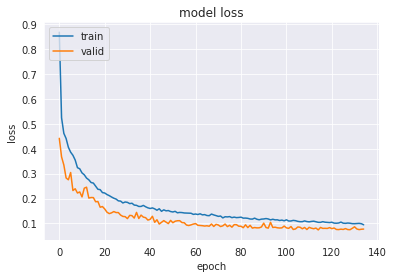

In [23]:
#%autoreload 2
(history_list, 

#scores_valid_list,
scores_test_list, 

#function_values_valid_list, 
function_values_test_list, 

#polynomial_dict_valid_list,
polynomial_dict_test_list,

#distrib_dict_valid_list,
distrib_dict_test_list,

model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [24]:
polynomial_dict_test_list[-1].keys()

dict_keys(['lstsq_lambda_pred_polynomials', 'lstsq_target_polynomials', 'target_polynomials', 'inet_polynomials', 'symbolic_regression_functions', 'per_network_polynomials'])

In [25]:
poly_optimize = tf.constant([float(i) for i in range(interpretation_net_output_shape)])

if interpretation_net_output_monomials != None:
    poly_optimize_coeffs = poly_optimize[:interpretation_net_output_monomials]

    poly_optimize_identifiers_list = []
    for i in range(interpretation_net_output_monomials):
        poly_optimize_identifiers = tf.math.softmax(poly_optimize[sparsity*i+interpretation_net_output_monomials:sparsity*(i+1)+interpretation_net_output_monomials])
        poly_optimize_identifiers_list.append(poly_optimize_identifiers)
    poly_optimize_identifiers_list = tf.keras.backend.flatten(poly_optimize_identifiers_list)
    poly_optimize = tf.concat([poly_optimize_coeffs, poly_optimize_identifiers_list], axis=0)


In [26]:
poly_optimize

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 2., 3., 4.], dtype=float32)>

In [27]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [28]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 76)]              0         
_________________________________________________________________
hidden1_512 (Dense)          (None, 512)               39424     
_________________________________________________________________
dropout1_0.25 (Dropout)      (None, 512)               0         
_________________________________________________________________
hidden2_1024 (Dense)         (None, 1024)              525312    
_________________________________________________________________
output_1024 (Dense)          (None, 5)                 5125      
Total params: 569,861
Trainable params: 569,861
Non-trainable params: 0
_________________________________________________________________
None
{'name': 'model', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 76), 'dtype': 'floa

In [29]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [30]:
scores_test_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
lambda_preds_VS_target_polynomials,NaN,NaN,NaN,NaN,NaN,0.042,0.102,0.077,-6.212,0.387,2.873,0.098,-0.172,-0.175,1.340,1.445
lambda_preds_VS_lstsq_lambda_pred_polynomials,NaN,NaN,NaN,NaN,NaN,0.022,0.031,0.061,0.979,0.052,0.221,0.031,-0.172,-0.172,1.340,1.344
lambda_preds_VS_lstsq_target_polynomials,NaN,NaN,NaN,NaN,NaN,0.042,0.102,0.077,-6.212,0.387,2.868,0.098,-0.172,-0.175,1.340,1.445
lambda_preds_VS_inet_polynomials,NaN,NaN,NaN,NaN,NaN,0.075,0.094,0.677,0.770,0.267,0.727,0.073,-0.172,-0.193,1.340,1.381
lambda_preds_VS_symbolic_regression_functions,NaN,NaN,NaN,NaN,NaN,inf,inf,inf,-inf,inf,-inf,inf,-0.172,inf,1.340,inf
lambda_preds_VS_per_network_polynomials,NaN,NaN,NaN,NaN,NaN,0.015,0.049,0.028,0.962,0.051,0.362,0.049,-0.172,-0.172,1.340,1.372
target_polynomials_VS_lstsq_lambda_pred_polynomials,2.103,6.658,54.404,0.318,0.060,0.047,0.093,0.088,-951801534934307128809095168.000,inf,inf,0.089,-0.175,-0.172,1.445,1.344
target_polynomials_VS_lstsq_target_polynomials,0.001,0.001,0.021,0.994,0.970,0.000,0.000,0.000,-36329764877307259912192.000,inf,inf,0.000,-0.175,-0.175,1.445,1.445
target_polynomials_VS_inet_polynomials,0.349,0.622,6.946,0.304,0.050,0.091,0.133,0.501,-469570914039976776989409280.000,inf,inf,0.116,-0.175,-0.193,1.445,1.381
target_polynomials_VS_symbolic_regression_functions,NaN,NaN,NaN,NaN,NaN,inf,inf,inf,-inf,inf,NaN,inf,-0.175,inf,1.445,inf


In [31]:
distrib_dict_test_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99
lambda_preds_VS_target_polynomials,0.113,0.009,0.089,0.096,0.004,0.004,0.009,0.011,0.006,0.015,0.005,0.020,0.006,0.007,0.009,0.004,0.168,0.003,0.004,0.007,0.048,0.005,0.011,0.011,0.004,0.008,0.000,0.007,0.121,0.008,0.004,0.008,0.069,0.003,0.150,0.014,0.007,0.010,0.003,0.013,0.004,0.009,0.005,0.009,0.004,0.002,0.006,0.011,0.004,0.109,0.003,0.136,0.144,0.017,0.007,0.004,0.003,0.000,0.006,0.010,0.006,0.003,0.000,0.007,0.004,0.006,0.096,0.011,0.121,0.003,0.004,0.013,0.003,0.112,0.009,0.002,0.006,0.011,0.011,0.007,0.008,0.546,0.004,0.017,0.811,0.013,0.079,0.034,0.072,0.010,0.000,0.007,0.010,0.007,0.009,0.003,0.005,0.123,0.343,0.075
lambda_preds_VS_lstsq_lambda_pred_polynomials,0.157,0.005,0.108,0.000,0.003,0.001,0.002,0.008,0.004,0.009,0.003,0.010,0.002,0.002,0.007,0.003,0.162,0.001,0.003,0.001,0.042,0.003,0.004,0.007,0.003,0.004,0.000,0.003,0.148,0.002,0.003,0.004,0.000,0.002,0.179,0.007,0.002,0.005,0.003,0.005,0.002,0.003,0.004,0.003,0.001,0.001,0.002,0.004,0.003,0.112,0.001,0.176,0.161,0.006,0.004,0.002,0.002,0.000,0.004,0.008,0.002,0.002,0.000,0.005,0.003,0.002,0.122,0.006,0.123,0.002,0.003,0.008,0.001,0.150,0.005,0.001,0.005,0.004,0.006,0.003,0.003,0.000,0.002,0.004,0.001,0.006,0.000,0.045,0.082,0.007,0.000,0.003,0.006,0.005,0.004,0.002,0.003,0.153,0.000,0.000
lambda_preds_VS_lstsq_target_polynomials,0.113,0.009,0.089,0.096,0.004,0.004,0.009,0.011,0.006,0.015,0.005,0.020,0.006,0.007,0.009,0.004,0.168,0.003,0.004,0.007,0.048,0.005,0.011,0.011,0.004,0.008,0.000,0.007,0.121,0.008,0.004,0.008,0.069,0.003,0.150,0.014,0.007,0.010,0.003,0.013,0.004,0.009,0.005,0.009,0.004,0.002,0.006,0.011,0.004,0.109,0.003,0.136,0.144,0.017,0.007,0.004,0.003,0.000,0.006,0.010,0.006,0.003,0.000,0.007,0.004,0.006,0.096,0.011,0.121,0.003,0.004,0.013,0.003,0.112,0.009,0.002,0.006,0.011,0.011,0.007,0.008,0.546,0.004,0.017,0.811,0.013,0.079,0.034,0.072,0.010,0.000,0.007,0.010,0.007,0.009,0.003,0.005,0.123,0.343,0.075
lambda_preds_VS_inet_polynomials,0.554,0.051,0.344,0.002,0.014,0.020,0.071,0.054,0.038,0.043,0.023,0.074,0.024,0.020,0.013,0.028,0.536,0.014,0.030,0.039,0.365,0.037,0.008,0.034,0.021,0.030,0.000,0.047,0.406,0.057,0.027,0.049,0.020,0.019,0.244,0.042,0.032,0.039,0.010,0.059,0.025,0.039,0.024,0.007,0.049,0.014,0.036,0.009,0.022,0.174,0.020,0.230,0.442,0.041,0.047,0.024,0.012,0.001,0.052,0.050,0.033,0.010,0.000,0.016,0.040,0.020,0.182,0.023,0.173,0.024,0.007,0.039,0.012,0.479,0.075,0.016,0.038,0.009,0.035,0.022,0.017,0.096,0.014,0.033,0.070,0.067,0.037,0.201,0.131,0.043,0.001,0.021,0.014,0.045,0.033,0.015,0.022,0.477,0.032,0.006
lambda_preds_VS_symbolic_regression_functions,0.089,0.030,0.068,0.010,0.028,0.010,0.030,0.029,0.025,0.025,0.025,0.021,0.007,0.007,0.022,0.076,0.207,0.025,0.006,inf,0.118,0.005,0.011,0.098,0.020,0.048,0.001,0.062,0.086,0.042,0.006,0.024,0.007,0.076,0.148,0.077,0.057,0.010,0.003,0.034,0.047,0.009,0.009,0.009,0.035,0.005,0.037,0.011,0.009,0.106,0.010,0.136,0.113,0.044,0.040,0.008,0.023,0.000,0.061,0.017,0.063,0.010,0.008,0.024,0.027,0.022,0.107,0.071,0.121,0.041,inf,0.035,0.013,0.100,0.039,0.010,0.006,0.011,0.055,0.030,0.057,0.034,0.032,0.064,inf,0.033,0.009,0.052,0.089,0.014,0.002,0.014,0.088,0.035,0.071,0.052,0.043,0.154,0.020,0.007
lambda_preds_VS_per_network_polynomials,0.087,0.005,0.058,0.000,0.003,0.001,0.002,0.008,0.004,0.009,0.003,0.010,0.002,0.002,0.006,0.003,0.157,0.001,0.003,0.002,0.034,0.003,0.003,0.008,0.003,0.004,0.000,0.003,0.071,0.002,0.003,0.004,0.001,0.002,0.105,0.007,0.003,0.005,0.002,0.006,0.002,0.005,0.004,0.003,0.001,0.00

In [32]:
distrib_dict_test_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99
lambda_preds_VS_target_polynomials,0.970,0.987,0.991,-491.717,0.998,0.999,0.999,0.999,0.999,0.983,0.998,0.995,0.993,0.994,0.998,0.998,0.887,0.979,0.978,0.999,0.896,0.999,-0.234,0.989,0.999,0.998,-0.147,0.981,0.983,0.999,0.998,0.998,0.627,0.997,0.972,0.960,0.981,0.998,0.999,0.974,0.999,0.998,0.998,-0.163,0.999,0.999,0.998,-0.106,0.997,0.970,0.999,0.966,0.970,0.995,0.999,0.999,0.998,-0.000,0.998,0.999,0.999,0.999,-0.513,0.890,0.999,0.993,0.969,0.975,0.978,0.999,0.996,0.995,0.999,0.974,0.999,0.997,0.998,-0.210,0.941,0.982,0.975,-33.568,0.998,0.993,-50.286,0.998,0.699,0.983,0.962,0.999,-0.036,0.995,0.991,0.998,0.981,0.999,0.983,0.962,-21.071,-108.342
lambda_preds_VS_lstsq_lambda_pred_polynomials,0.991,0.997,0.995,0.999,0.999,1.000,1.000,0.999,1.000,0.996,1.000,0.999,1.000,1.000,0.999,0.999,0.990,0.997,0.990,1.000,0.987,1.000,0.954,0.996,1.000,1.000,0.356,0.997,0.993,1.000,0.999,1.000,1.000,0.999,0.991,0.992,0.998,1.000,1.000,0.997,1.000,1.000,0.999,0.952,1.000,1.000,1.000,0.957,0.999,0.994,1.000,0.990,0.992,1.000,1.000,1.000,1.000,0.786,1.000,1.000,1.000,1.000,0.624,0.966,1.000,0.999,0.991,0.994,0.993,1.000,0.999,0.999,1.000,0.991,1.000,1.000,0.999,0.955,0.988,0.999,0.997,1.000,1.000,1.000,1.000,1.000,1.000,0.995,0.991,1.000,0.594,0.999,0.998,1.000,0.996,0.999,0.996,0.991,1.000,0.999
lambda_preds_VS_lstsq_target_polynomials,0.970,0.987,0.991,-491.637,0.998,0.999,0.999,0.999,0.999,0.983,0.998,0.995,0.993,0.994,0.998,0.998,0.887,0.979,0.978,0.999,0.896,0.999,-0.234,0.989,0.999,0.998,-0.224,0.981,0.983,0.999,0.998,0.998,0.627,0.997,0.972,0.961,0.981,0.998,0.999,0.974,0.999,0.998,0.998,-0.166,0.999,0.999,0.998,-0.105,0.997,0.970,0.999,0.966,0.970,0.995,0.999,0.999,0.998,0.018,0.998,0.999,0.999,0.999,-0.508,0.890,0.999,0.993,0.969,0.975,0.978,0.999,0.996,0.995,0.999,0.974,0.999,0.997,0.998,-0.211,0.941,0.982,0.975,-33.568,0.998,0.993,-50.286,0.998,0.699,0.983,0.962,0.999,-0.008,0.995,0.991,0.998,0.981,0.999,0.983,0.962,-21.071,-108.331
lambda_preds_VS_inet_polynomials,0.926,0.661,0.972,0.861,0.978,0.974,0.963,0.940,0.957,0.887,0.979,0.961,0.883,0.967,0.996,0.963,0.921,0.682,0.309,0.965,0.468,0.961,0.761,0.906,0.973,0.985,-0.596,0.295,0.968,0.958,0.948,0.932,0.955,0.955,0.980,0.682,0.546,0.985,0.994,0.545,0.973,0.975,0.945,0.761,0.968,0.928,0.978,0.735,0.978,0.978,0.965,0.977,0.966,0.979,0.978,0.987,0.983,-3.854,0.959,0.965,0.984,0.992,0.051,0.573,0.945,0.936,0.984,0.930,0.986,0.981,0.994,0.961,0.957,0.950,0.971,0.852,0.952,0.712,0.524,0.899,0.917,0.657,0.990,0.984,0.874,0.968,0.936,0.925,0.976,0.976,-4.167,0.931,0.991,0.978,0.800,0.969,0.780,0.938,0.923,0.449
lambda_preds_VS_symbolic_regression_functions,0.973,0.865,0.993,-0.926,0.926,0.996,0.990,0.988,0.991,0.969,0.974,0.997,0.989,0.996,0.994,0.819,0.881,-0.198,0.969,-inf,0.872,0.999,-0.130,-0.337,0.991,0.961,-22.476,-0.081,0.989,0.984,0.997,0.972,0.997,-0.205,0.984,-0.085,-0.144,0.999,0.998,0.850,0.928,0.998,0.995,-0.209,0.981,0.995,0.982,-0.228,0.989,0.987,0.991,0.981,0.975,0.976,0.987,0.999,0.943,-0.149,0.938,0.997,0.933,0.990,-499.490,-0.028,0.980,0.892,0.984,-0.253,0.983,0.926,-inf,0.970,0.970,0.986,0.992,0.939,0.998,-0.115,-0.031,0.747,-0.400,0.955,0.953,0.941,-inf,0.994,0.996,0.989,0.976,0.998,-18.670,0.986,0.611,0.986,-0.114,0.830,-0.064,0.982,0.971,0.135
lambda_preds_VS_per_network_polynomials,0.974,0.997,0.994,0.999,0.999,1.000,1.000,0.999,1.000,0.995,1.000,0.999,0.999,1.000,0.999,0.999,0.912,0.996,0.990,1.000,0.972,1.000,0.872,0.995,1.000,1.000,0.236,0.996,0.988,1.000,0.999,1.000,1.000,0.999,

In [33]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_min]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

-0.21730120088620897


-0.000829195894766599*a**3 - 0.00672092847526073*a**2 - 0.0162914134562016*a - 0.279616475105286 + 0.00179649924393743/a

In [34]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['lstsq_lambda_pred_polynomials_VS_inet_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

-1.8192444183307783


-0.0045896358765226*a**3 + 0.0095192802555899*a**2 - 0.0056166350454547*a - 0.0756604132607729 - 6.15145948805376e-5/a

In [35]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.358577661691335*a**2 - 0.0733289685207083/a

In [36]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_max]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.9674747243885689


0.407357782125473*a**3 + 0.348508358001709*a**2 + 0.247111812233925*a - 0.281360805034637 - 0.00293428800068796/a

In [37]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9994950726813034


-0.320895534083798*a**3 + 0.689300532596754*a**2 + 0.745527863105319*a - 0.484589902458391 + 0.0041883414855363/a

In [38]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.321099511356793*a**3 + 0.76185494020331*a**2 + 0.649776105043393*a - 0.44943393053626

In [39]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -4.695709140399768e+26 (100 Samples)
Mean (only positive): 0.8924641516012133 (89 Samples)


In [40]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: -9.518015349343071e+26 (100 Samples)
Mean (only positive): 0.9653814910501028 (89 Samples)


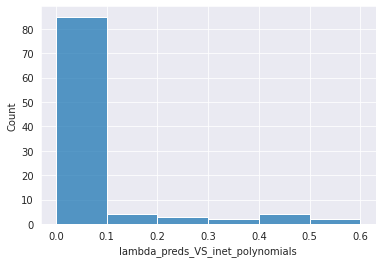

In [41]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

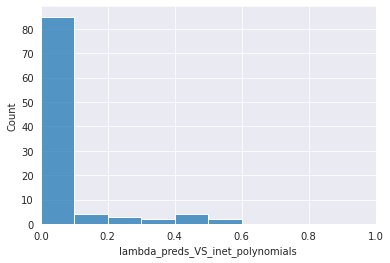

In [42]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


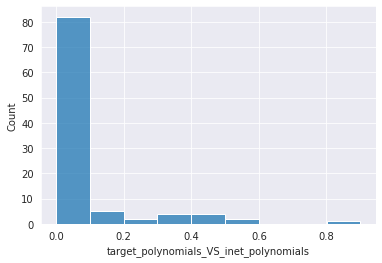

In [43]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

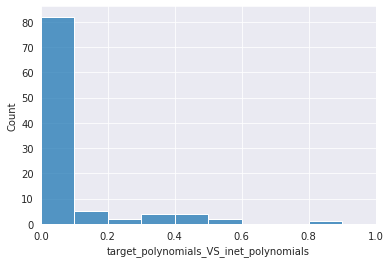

In [44]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


[(-30.0, 1.0)]

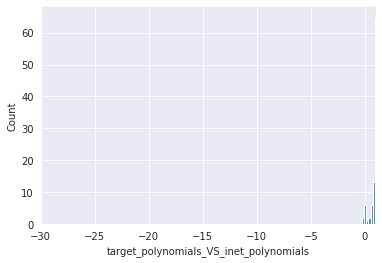

In [45]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

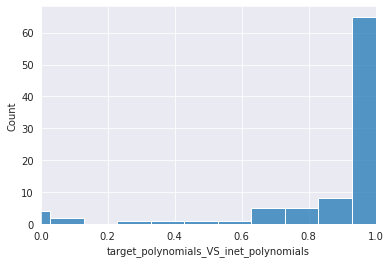

In [46]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

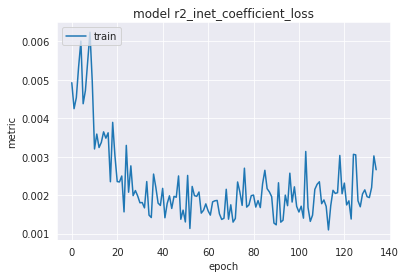

In [47]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


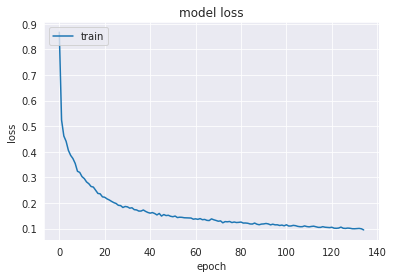

In [48]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [49]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [50]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [51]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [52]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


0.3954*a**3 - 0.9974*a**2 - 0.9904*a + 0.4129 - 0.0073/a

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_target_polynomials


0.2524*a**3 - 0.9141*a**2 - 0.916*a + 0.3587

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


0.2509*a**3 - 0.9117*a**2 - 0.9173*a + 0.3589

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


-0.70990002155304*a**3 - 0.516600012779236*a**2 - 0.150099992752075*a - 0.000699999975040555 + 0.0115999998524785/a

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
symbolic_regression_functions


0.503 - 1.648*x

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
per_network_polynomials


0.428299993276596*a**3 - 1.05089998245239*a**2 - 0.963800013065338*a + 0.408100008964539 - 0.0071000000461936/a

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


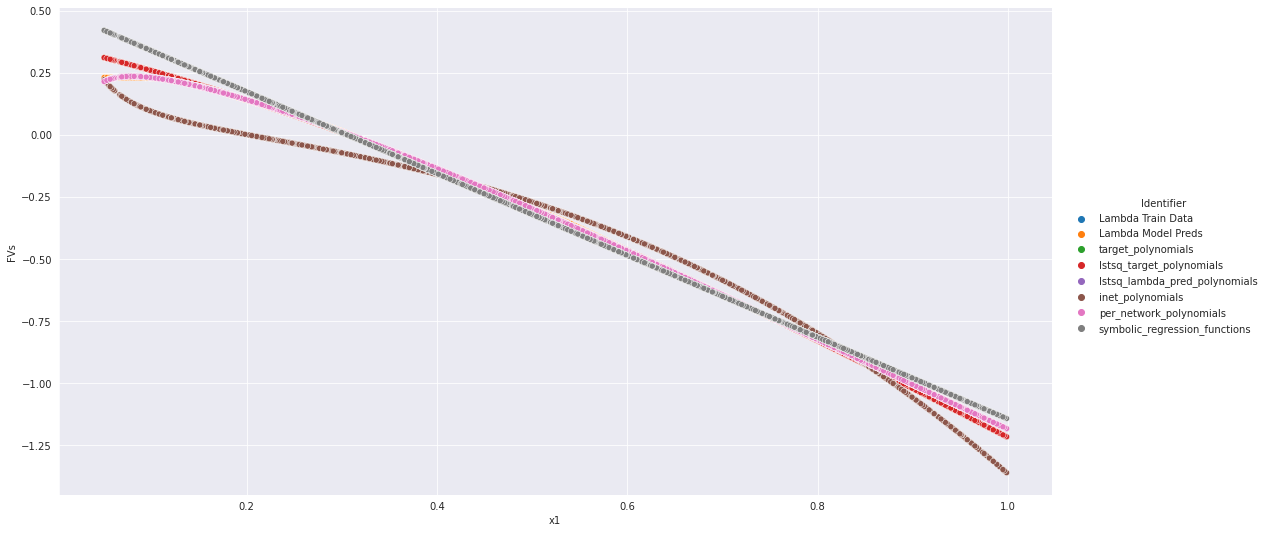

In [53]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

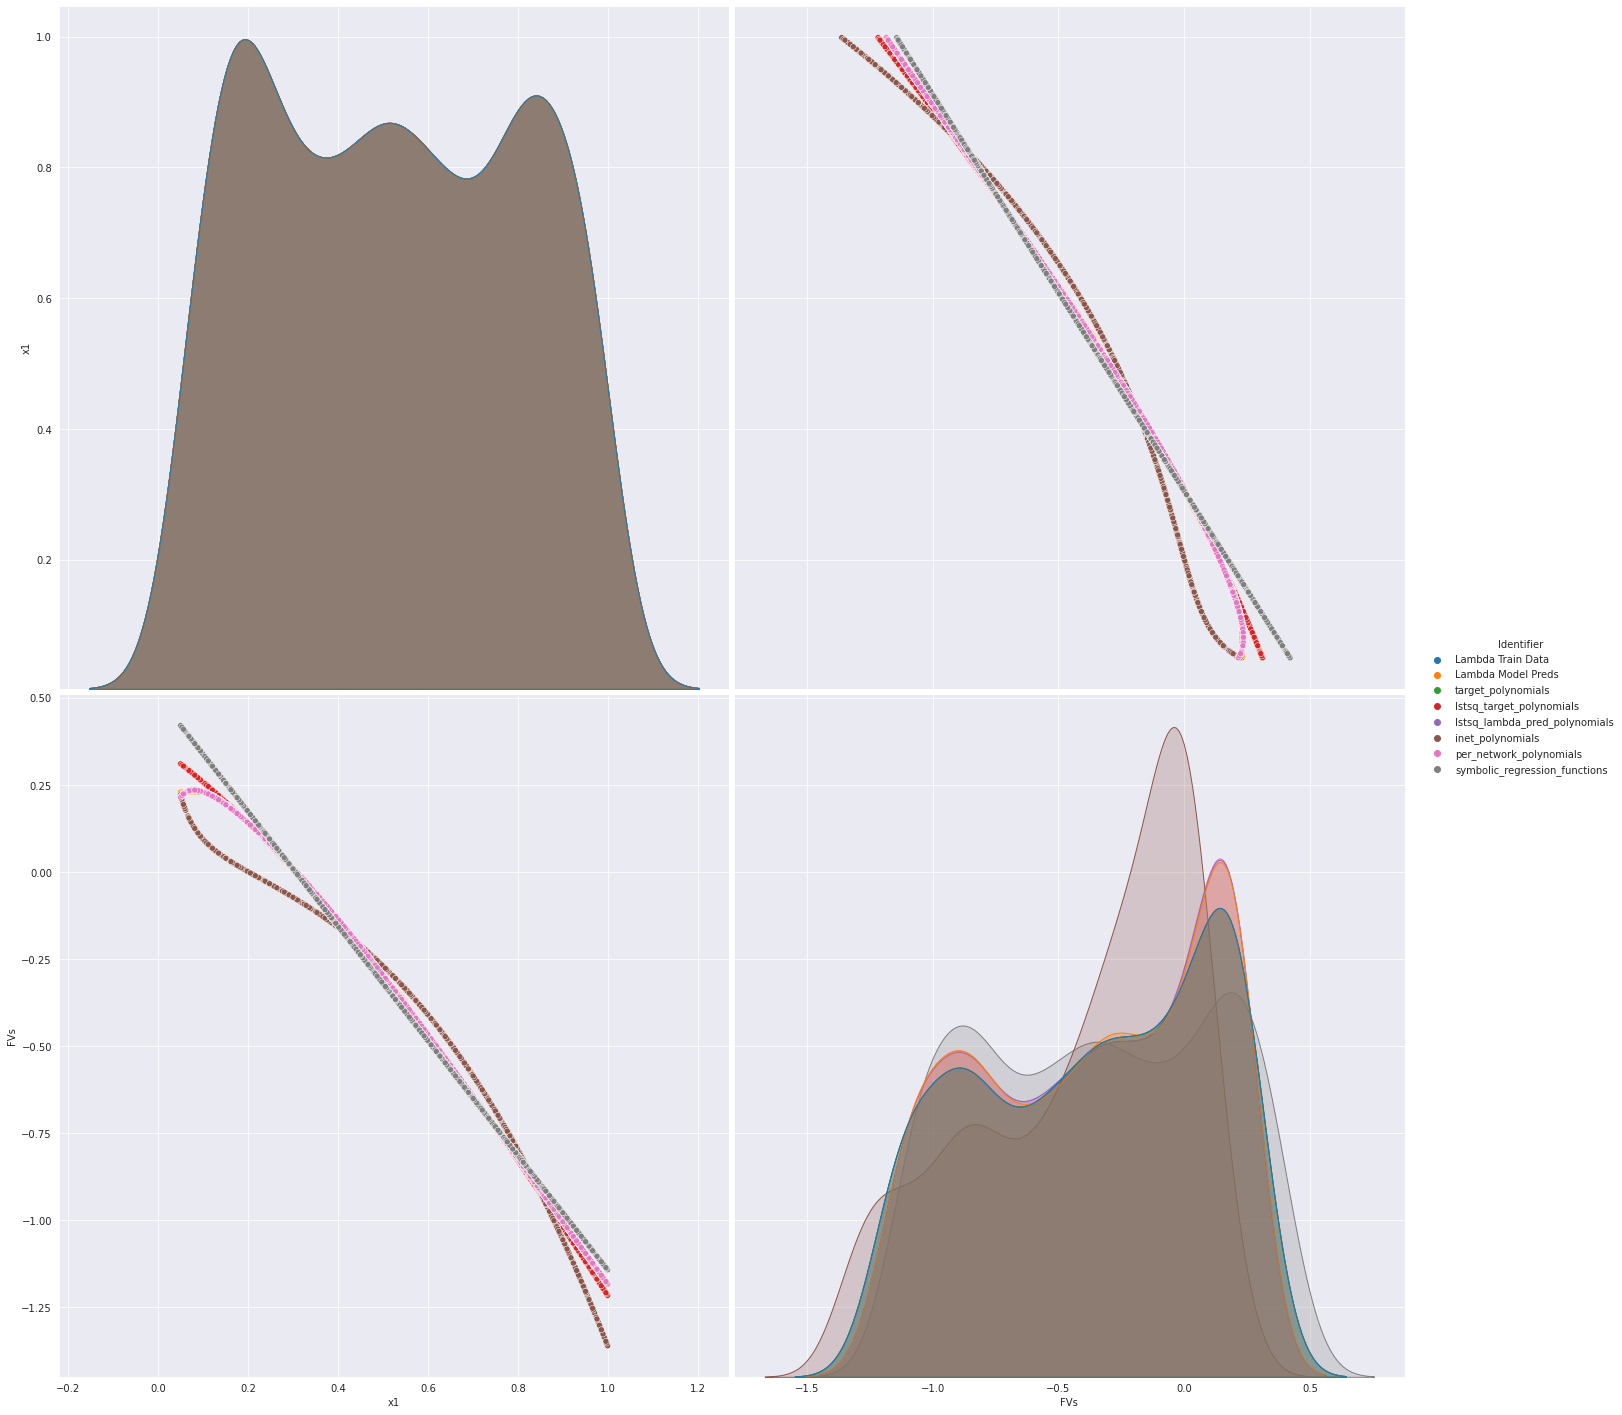

In [54]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

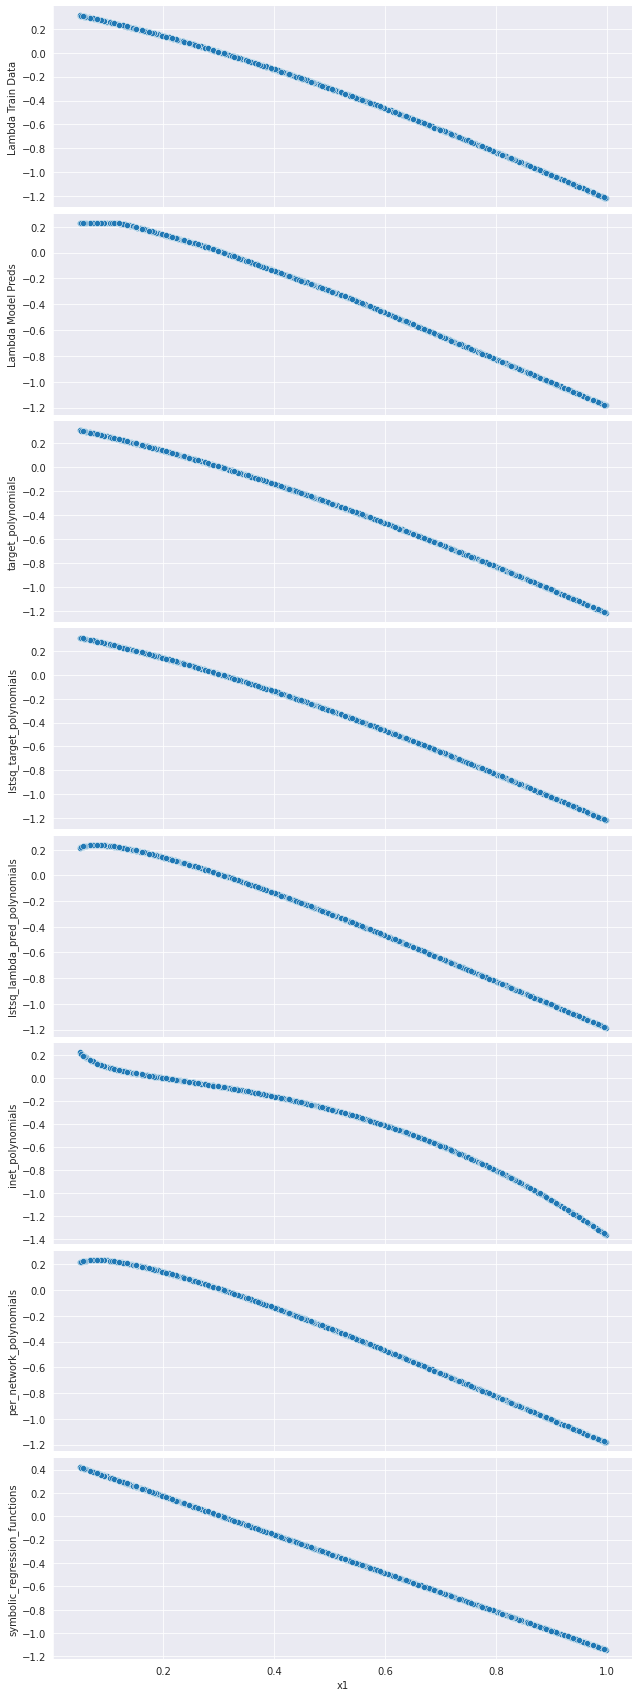

In [55]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [56]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [57]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [58]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.2344


In [59]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 18.1967


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [60]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [61]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.7827


In [62]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [63]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


Current best: 0.11968284845352173 
 Curr_res: 0.1513930708169937 
 Iteration 1, Step 64
Optimization terminated at 0.11968284845352173


array([ 0.6088386 , -0.08147161, -0.09718028, -0.526358  , -0.84311754],
      dtype=float32)

# Evaluate Real Dataset


##  Auto MPG-Dataset

In [64]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == train_features_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

,Horsepower
0,0.457
1,0.647
2,0.565
3,0.565
4,0.511


In [65]:
#%load_ext autoreload

In [66]:
np.isinf(features_autoMPG_model.values).any()

False

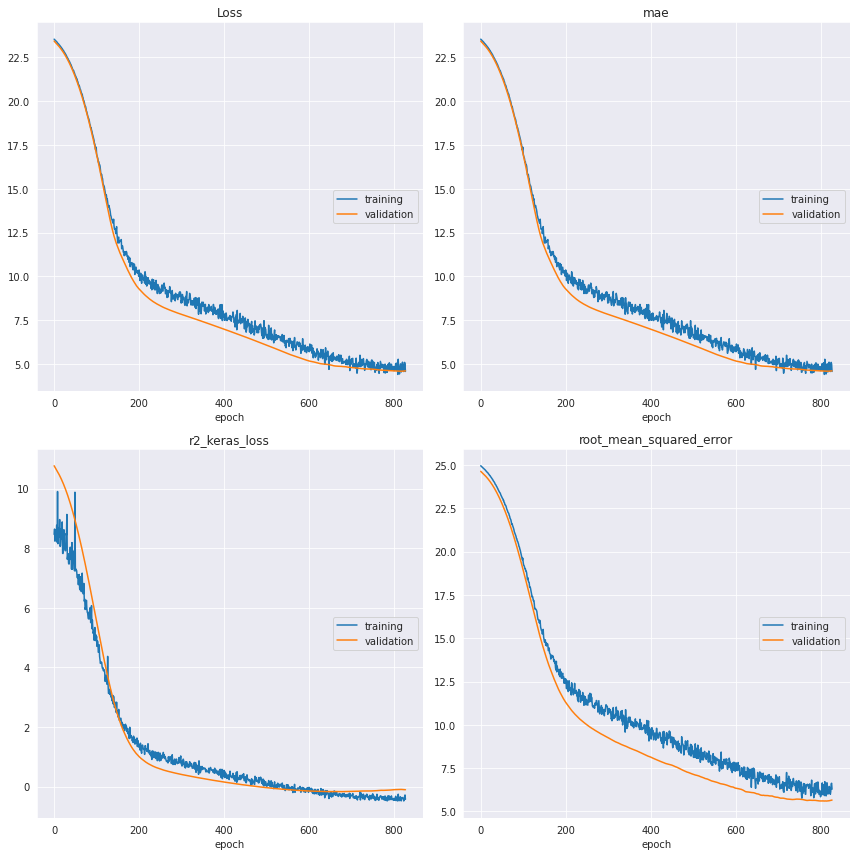

Loss
	training         	 (min:    4.405, max:   23.546, cur:    4.575)
	validation       	 (min:    4.591, max:   23.438, cur:    4.610)
mae
	training         	 (min:    4.405, max:   23.546, cur:    4.575)
	validation       	 (min:    4.591, max:   23.438, cur:    4.610)
r2_keras_loss
	training         	 (min:   -0.485, max:    9.899, cur:   -0.427)
	validation       	 (min:   -0.169, max:   10.763, cur:   -0.106)
root_mean_squared_error
	training         	 (min:    5.770, max:   24.949, cur:    6.287)
	validation       	 (min:    5.604, max:   24.628, cur:    5.659)


In [67]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

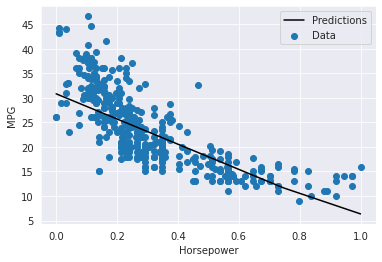

In [68]:
if interpretation_possible_autoMPG:
    x = tf.linspace(0.0, 1, 250)#tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [69]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [70]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LSTSQt Poly:


27.4460977223591*a**3 + 28.8492788191157*a**2 + 21.1979011380753*a + 27.5832083747038 + 25.2551831852739/a

MAE Model:  1.834380749859506e+306
MAE Data:  1.834380749859506e+306
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [72]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, normalized=False, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation Net Poly:


4.85830307006836*a**3 + 2.42143774032593*a**2 - 0.191201463341713*a + 9.42650604248047 + 0.422804743051529/a

MAE Model:  1.834380749859506e+306
MAE Data:  1.834380749859506e+306
Computation Time: 0:00:00
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [73]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


Current best: 2.4114694595336914 
 Curr_res: 2.404229164123535 
 Iteration 2, Step 499
Optimization terminated at 2.2765183448791504
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Network Poly:


-6.5969033241272*a**3 - 5.5925030708313*a**2 + 5.17999458312988*a + 10.817006111145 + 2.41020250320435/a

MAE Model:  1.834380749859506e+306
MAE Data:  1.834380749859506e+306
Computation Time: 0:00:17
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [74]:
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81          2443.82       63          4.57753          4.31385      3.90m
   1    37.94          23.5337       63          2.07665          2.01181      2.49m
   2    51.91          35.0156       63          1.31778          1.24599      2.81m
   3    60.99           26.942       49         0.807791         0.793189      2.85m
   4    62.04          33.5347       63         0.640618         0.727465      2.68m
   5    60.80          43.5023       67         0.520806         0.504628      2.44m
   6    58.56          28.4207       47         0.469278         0.397384      2.19m
   7    52.33          36.3288       47         0.450584         0.472769      1.95m
   8    46.04          32.3246       47         0.449722          0.48053  

(0.196*x**4 - 3.74116584615385*x**3 - 7.02871336529738*x**2 + 14.4173175980809*x + 0.02365)/(x*(0.196*x + 0.473))

MAE Model:  1.834380749859506e+306
MAE Data:  1.834380749859506e+306
Computation Time: 0:03:58
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [75]:
#%autoreload 2
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [76]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [77]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function:')
    #display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation Net Poly:


4.85830307006836*a**3 + 2.42143774032593*a**2 - 0.191201463341713*a + 9.42650604248047 + 0.422804743051529/a

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Network Poly:


-6.5969033241272*a**3 - 5.5925030708313*a**2 + 5.17999458312988*a + 10.817006111145 + 2.41020250320435/a

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LSTSQ Poly:


8.08235774464768*a**3 - 10.3865638838206*a**2 - 21.466387459893*a + 30.216777839808 + 0.024529146637132/a

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Symbolic Regression Function:


(0.196*x**4 - 3.74116584615385*x**3 - 7.02871336529738*x**2 + 14.4173175980809*x + 0.02365)/(x*(0.196*x + 0.473))

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


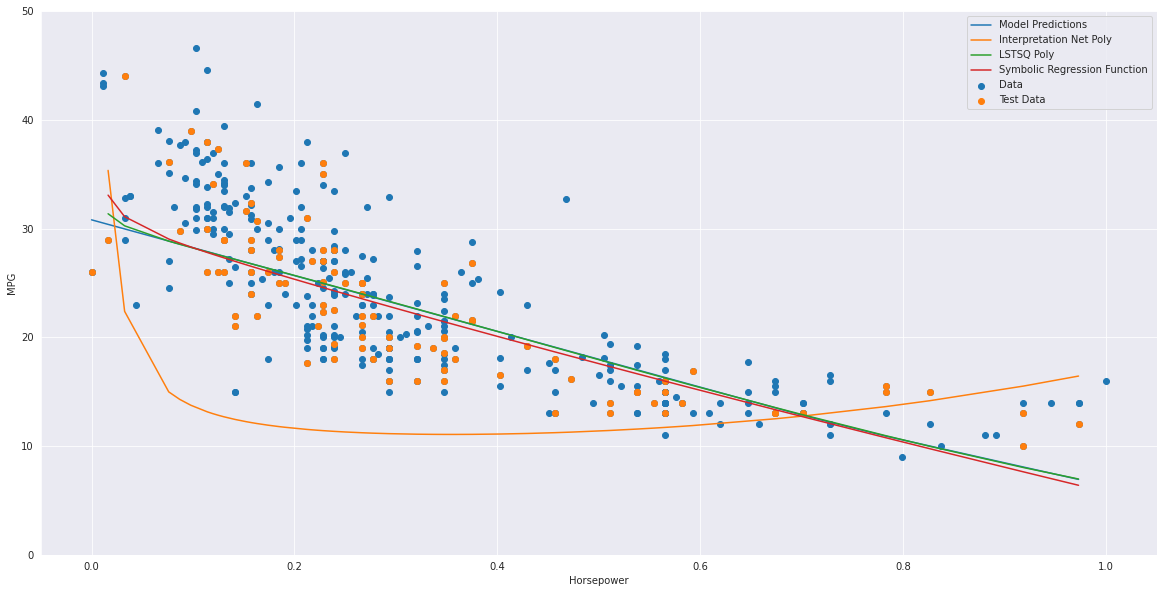

In [78]:
if interpretation_possible_autoMPG:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])


In [ ]:
current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y,
         epochs=500,
         verbose=0)

In [ ]:
model_2 = keras.models.clone_model(model)

model_2.summary()

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]

In [ ]:
model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

In [ ]:
#model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/1000
#model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

In [ ]:
model_2.set_weights(model_2_normalized_weights)

In [ ]:
model_2.get_weights()

In [ ]:
model_2.predict([1, 10])

In [ ]:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    if length_plt >= 2:
        fig, ax = plt.subplots(length_plt//2, 2, figsize=(30,20))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(20,10))

    for index, metric in enumerate(plot_metric_list):
        
        plot_scores_dict = {}
        for key in evaluation_key_list:
            try:
                scores_list[-1][metric].loc[key]
                plot_scores_dict[key] = []
            except:
                #print(key + 'not in scores_list')
                continue
            
        
        for scores in scores_list:
            for key in evaluation_key_list:
                try:
                    plot_scores_dict[key].append(scores[metric].loc[key])
                except:
                    #print(key + 'not in scores_list')
                    continue
                                        
            
        plot_df = pd.DataFrame(data=np.vstack(plot_scores_dict.values()).T, 
                               index=x_axis_steps,
                               columns=plot_scores_dict.keys())

        if length_plt >= 2:
            ax[index//2, index%2].set_title(metric)
            sns.set(font_scale = 1.25)
            p = sns.lineplot(data=plot_df, ax=ax[index//2, index%2])
        else:
            ax.set_title(metric)
            sns.set(font_scale = 1.25)
            p = sns.lineplot(data=plot_df, ax=ax)

        if ylim != None:
            p.set(ylim=ylim)

        p.set_yticklabels(np.round(p.get_yticks(), 2), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)     
        
        #p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        p.legend(loc='upper center', bbox_to_anchor=(0.47, -0.1),
          fancybox=False, shadow=False, ncol=2, fontsize=12)   
        
    plt.subplots_adjust(wspace=0.1, hspace=0.75)

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()